## Importar as bibliotecas

In [ ]:
import tensorflow as tf

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTOTUNE

-1

In [ ]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
tf.__version__

'2.3.0'

## Carregar o dataset

Fonte: http://download.tensorflow.org/example_images/flower_photos.tgz

In [ ]:
import pathlib

data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['tulips', 'sunflowers', 'daisy', 'dandelion', 'roses'],
      dtype='<U10')

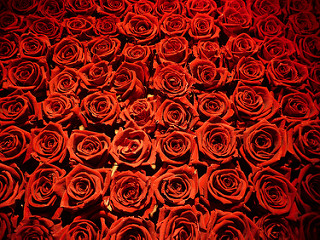

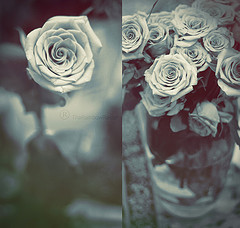

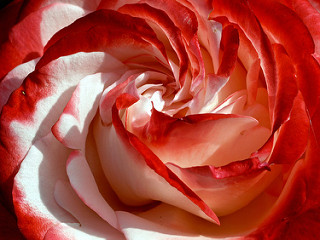

In [ ]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Carregar usando keras.preprocessing

In [ ]:
# 1./255 para converter de uint8 para float32 no intervalo (0,1)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [ ]:
str(data_dir)

'/root/.keras/datasets/flower_photos'

In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=BATCH_SIZE, shuffle=True, target_size=(IMG_HEIGHT, IMG_WIDTH), classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

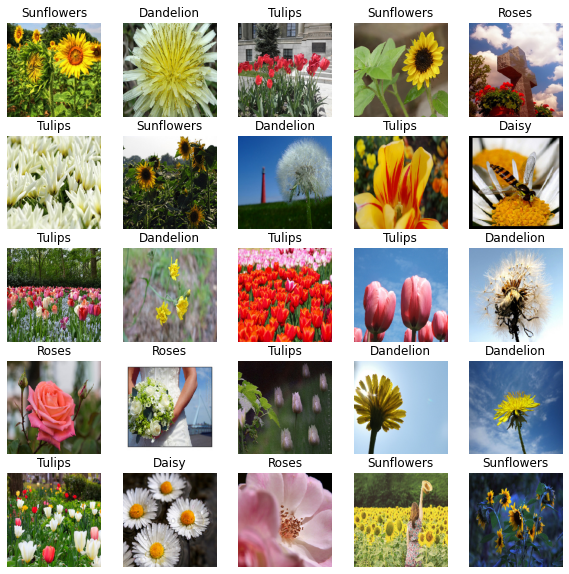

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Carregar usando tf.data

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/23247483352_0defc7a6dc_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3704306975_75b74497d8.jpg'
b'/root/.keras/datasets/flower_photos/daisy/14088053307_1a13a0bf91_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4806174512_e04475b766_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/20825078671_90b0389c70_m.jpg'


In [ ]:
def get_label(file_path):
    # converte o caminho para uma lista de componentes de caminho
    parts = tf.strings.split(file_path, os.path.sep)
    # o penúltimo elemento são os diretórios das classes
    return parts[-2] == CLASS_NAMES

In [ ]:
def decode_img(img):
    # converte a string compactada para um tensor do tipo unint8 tridimensional
    img = tf.image.decode_jpeg(img, channels=3)
    # usa o 'convert_image_dtype' para converter floats no intervalo (0,1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # redimensiona a imagem para o tamanho desejado
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # carrega os dados brutos do arquivo em formato string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
# 'num_parallel_calls' é definido para que múltiplas imagens sejam carregadas ou processadas em paralelo
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
    print(f"Dimensões da imagem: {image.numpy().shape}")
    print(f"Rótulo: {label.numpy()}")

Dimensões da imagem: (224, 224, 3)
Rótulo: [ True False False False False]


## Métodos básicos para treinamento

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # este é um pequeno dataset e, uma vez carregado, é mantido em memória.
    # use '.cache(filename)' para armazenar em cache o trabalho preprocessado sobre datasets que excedam a memória
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # repete o processo ininterruptamente
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # 'prefetch' permite que o dataset busque lotes em plano de fundo enquanto o modelo é treinado
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

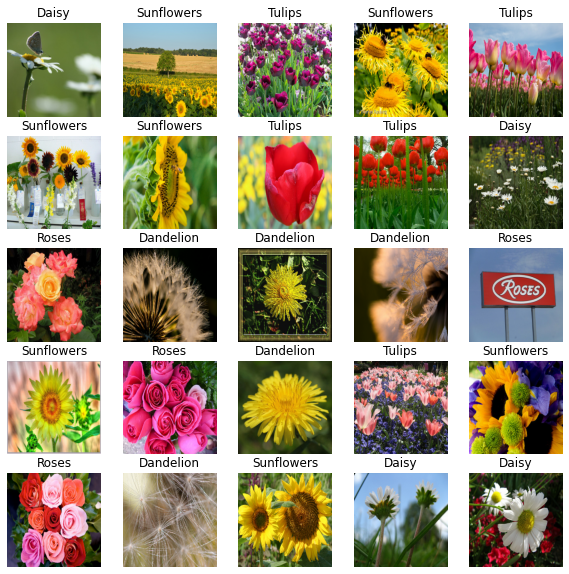

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

In [ ]:
import time
default_timeit_steps = 1000

In [ ]:
def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i % 10 == 0:
            print('.', end=' ')
    print()
    end = time.time()

    duration = end - start
    
    print(f"{steps} batches: {duration} s")
    print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [ ]:
# 'keras.preprocessing'
timeit(train_data_gen)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
1000 batches: 95.48797869682312 s
335.12072 Images/s


In [ ]:
# 'tf.data'
timeit(train_ds)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
1000 batches: 9.55257248878479 s
3349.88298 Images/s


In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
1000 batches: 55.63467717170715 s
575.18083 Images/s


In [ ]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
1000 batches: 26.28643035888672 s
1217.35814 Images/s
